## GPT 4o Code to generate image text pairs

### Installing openai python library

In [4]:
!pip3 install --upgrade openai --quiet

### Getting API_key

In [15]:
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY=os.getenv("PERSONAL_OPENAI_API_KEY")

### Importing necessary libraries

In [16]:
from openai import OpenAI
from IPython.display import Image, display
import base64
from PIL.Image import fromarray

MODEL = "gpt-4o"
client = OpenAI(api_key=API_KEY)

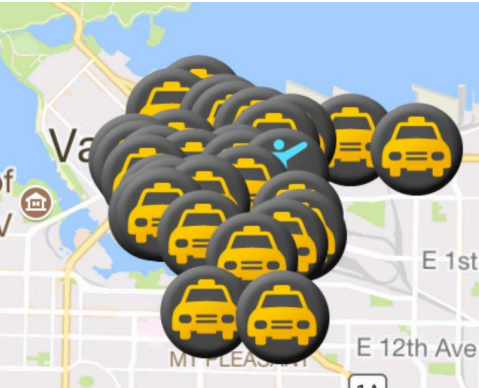

In [19]:
IMAGE_PATH = "Sample Images/Traffic.png"

def encode_image(image_path : str) -> bytes:
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)
display(Image(IMAGE_PATH))

In [20]:
def provide_prompt(questions_generated: str = "text") -> list[str]:
    # Define the prompt for GPT-4
    prompt = """
    You are given a pair of text and image. Your task is to determine whether sarcasm is present using the following guidelines:

    1. First, ignore the image and analyze the text alone to see if it is sarcastic.
    2. Next, ignore the text and analyze the image alone to determine if it conveys sarcasm.
    3. Finally, consider the text and image together to see if they reinforce each other to create an overall sarcastic impression.

    Use 1 to indicate sarcasm and 0 if no sarcasm is detected.

    Here are a few examples:
    """

    examples = [
        (
            "Text associated with image is: strange bedfellows why is this so relatable?",
            f"data:image/png;base64,{encode_image('Sample Images/ayezy8.png')}",
            """{"isTextSarcastic?": 0, "isImageSarcastic?": 1, "isTogetherSarcastic?": 1}"""
        ),
        (
            "Text associated with image is: calm down 50 points for actually putting a camera in",
            f"data:image/png;base64,{encode_image('Sample Images/epymwl.png')}",
            """{"isTextSarcastic?": 0, "isImageSarcastic?": 1, "isTogetherSarcastic?": 1}"""
        ),
        (
            "Text associated with image is:  the cable guy installed the cable through our hula hoop that we left out. makes sense. cable companies popularity ranks somewhere between flying cockroaches and dog shit stuck to your shoe.",
            f"data:image/png;base64,{encode_image('Sample Images/cable.png')}",
            """{"isTextSarcastic?": 1, "isImageSarcastic?": 0, "isTogetherSarcastic?": 1}"""
        ),
        (
            "Text associated with image is: my husband keeps opening new jars of jam before he's even finished the last one. 1 or 2 i could understand, but at this point i would seek help",
            f"data:image/png;base64,{encode_image('Sample Images/jam.png')}",
            """{"isTextSarcastic?": 1, "isImageSarcastic?": 0, "isTogetherSarcastic?": 1}"""
        ),
        (
            "Text associated with image is: snake violently comitted suicide",
            f"data:image/png;base64,{encode_image('Sample Images/snake.png')}",
            """{"isTextSarcastic?": 0, "isImageSarcastic?": 0, "isTogetherSarcastic?": 1}"""
        ),
        (
            "Text associated with image is: Ahh, such a shortage of cabs in the city.",
            f"data:image/png;base64,{encode_image('Sample Images/Traffic_bounded.png')}",
            """{"isTextSarcastic?": 0, "isImageSarcastic?": 0, "isTogetherSarcastic?": 1}""",
        ),
        (
            "Text associated with image is: i put that shit right there, said the jesus calmly god was calling them to heaven!",
            f"data:image/png;base64,{encode_image('Sample Images/tumor.png')}",
            """{"isTextSarcastic?": 1, "isImageSarcastic?": 1, "isTogetherSarcastic?": 1}""",
        ),
        (
            "Text associated with image is: in a time before selfies my apologies, it hath already been snap-chatted to thine peeps milady",
            f"data:image/png;base64,{encode_image('Sample Images/oil_painting.png')}",
            """{"isTextSarcastic?": 1, "isImageSarcastic?": 1, "isTogetherSarcastic?": 1}""",
        ),
        (
            "Text associated with image is: had a great visit today at east texas baptist university!",
            f"data:image/png;base64,{encode_image('Sample Images/university.png')}",
            """{"isTextSarcastic?": 0, "isImageSarcastic?": 0, "isTogetherSarcastic?": 0}""",
        ),
        (
            "Text associated with image is: january 's plant of the month is lotus flowers , a symbol of how great beauty can arise from the most abject of conditions . happy saturday !",
            f"data:image/png;base64,{encode_image('Sample Images/lotus.png')}",
            """{"isTextSarcastic?": 0, "isImageSarcastic?": 0, "isTogetherSarcastic?": 0}""",
        )
    ]

    message = [ {"role": "system", "content": prompt} ]


    for caption, image, resp in examples:
        message = message + [
                                {"role": "user", "content":
                                [
                                    {"type": "text", "text":caption},
                                    {"type": "image_url", "image_url": {"url": image}}
                                ],
                                },
                                {"role": "assistant", "content" : resp},
                            ]

    return message

In [21]:
def generate_questions_and_answers(image_path : str, text : str) -> str:


    # Call the GPT-4 API to generate questions
    response = client.chat.completions.create(
        model=MODEL,
        messages= provide_prompt() + [
        {"role": "user", "content":
         [
            {"type": "text", "text": "Text associated with image is "+text},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encode_image(image_path)}"}}
         ]
        }
        ],
    )

    questions_and_answers = response.choices[0].message.content
    return questions_and_answers


In [22]:
def process_image_text_pairs(image_text_pairs: list[ tuple[ str, str] ]) -> list[ tuple[str,str,str] ]:
    results = []
    for image_path, text in image_text_pairs:
        result = generate_questions_and_answers(image_path, text)
        results.append((image_path, text, result))
    return results

In [23]:
def main():
    image_text_pairs= [
        ('Sample Images/bill.png', "helicopter ride to the hospital if they showed me the bill mid flight i would have jumped out."),
        ('Sample Images/airpod.png', "this rock looks like an airpod case it is obviously for rock music"),
        ('Sample Images/beard.png', "so the advice here is if you want to keep your hair on your head you shouldn't play guitar i think this is a compliment, friend"),
        ('Sample Images/sleep.png', "dirt nap sleep is just death being shy"),
    ]

    results = process_image_text_pairs(image_text_pairs)

    for image_path, text, result in results:
        print(f"Image: {image_path}")
        print(f"Text assoicated with image: {text}")
        print("Response:")
        print(result)
        print("\n---\n")

In [24]:
if __name__ == "__main__":
    main()

Image: Sample Images/bill.png
Text assoicated with image: helicopter ride to the hospital if they showed me the bill mid flight i would have jumped out.
Response:
{"isTextSarcastic?": 1, "isImageSarcastic?": 0, "isTogetherSarcastic?": 1}

---

Image: Sample Images/airpod.png
Text assoicated with image: this rock looks like an airpod case it is obviously for rock music
Response:
{"isTextSarcastic?": 1, "isImageSarcastic?": 0, "isTogetherSarcastic?": 1}

---

Image: Sample Images/beard.png
Text assoicated with image: so the advice here is if you want to keep your hair on your head you shouldn't play guitar i think this is a compliment, friend
Response:
{"isTextSarcastic?": 1, "isImageSarcastic?": 0, "isTogetherSarcastic?": 1}

---

Image: Sample Images/sleep.png
Text assoicated with image: dirt nap sleep is just death being shy
Response:
{"isTextSarcastic?": 1, "isImageSarcastic?": 0, "isTogetherSarcastic?": 1}

---



In [4]:
A= [1,0,1,0,1]
B = [1,0,0,1,1]